In [98]:
# import libraries
import pandas as pd
import nltk
import numpy as np

from sqlalchemy import create_engine
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [99]:
nltk.download(['punkt','stopwords','wordnet'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tati\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tati\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tati\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [100]:
# save stop words in english
stop_english = stopwords.words("english")

In [125]:
def tokenize(text):
    # normalize and tokenize
    tokens = word_tokenize(text.lower())
    
    # remove stop words
#     tokens = [word for word in tokens if word not in stop_english]
    
    # lemmatize nouns
    tokens = [WordNetLemmatizer().lemmatize(word) for word in tokens]
    
    # lemmatize verbs
    tokens = [WordNetLemmatizer().lemmatize(word, pos = 'v') for word in tokens]
    
    # remove trailing space
    tokens = list(map(str.strip, tokens))
    
    return tokens

In [102]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql('SELECT * FROM Messages', engine)

In [103]:
X = df['message']
y = df.drop(columns=['id', 'message', 'original','genre'])

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=10)

In [105]:
(y_train == 0).mean()

related                   0.228556
request                   0.829155
offer                     0.995858
aid_related               0.584687
medical_help              0.919128
medical_products          0.949918
search_and_rescue         0.971935
security                  0.982125
military                  0.967793
water                     0.935313
food                      0.886921
shelter                   0.910082
clothing                  0.985286
money                     0.976621
missing_people            0.988447
refugees                  0.967193
death                     0.953569
other_aid                 0.868992
infrastructure_related    0.934823
transport                 0.953896
buildings                 0.949809
electricity               0.978147
tools                     0.993733
hospitals                 0.989046
shops                     0.995150
aid_centers               0.988501
other_infrastructure      0.955804
weather_related           0.718692
floods              

In [128]:

from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None))),
               ])

In [107]:
sgd.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=<function tokenize at 0x000001BF45736678>,
                   vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf',
   MultiOutputClassifier(estimator=SGDClassifier(alpha=0.001, average=False,
                                                 class_weight=None,
                                                 early_stopping=False, epsilon=0.1,
                                                 eta0=0.0, fit_intercept=True,
                                                 l1_ratio=

In [108]:
import time

start = time.time()

sgd.fit(X_train, y_train)

y_pred_sgd = sgd.predict(X_test)

end = time.time()
print(end - start)

15.718690395355225


In [109]:
test_pred = pd.DataFrame(y_pred_sgd, columns=list(y.columns))

In [110]:
test_y = y_test.reset_index(drop=True)

In [111]:
for col in list(y.columns):
    print(col)
    print (classification_report(test_y[col], test_pred[col], zero_division=0))

related
              precision    recall  f1-score   support

           0       0.79      0.06      0.11      1928
           1       0.77      0.99      0.87      5937

    accuracy                           0.77      7865
   macro avg       0.78      0.53      0.49      7865
weighted avg       0.77      0.77      0.68      7865

request
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      6526
           1       0.89      0.34      0.50      1339

    accuracy                           0.88      7865
   macro avg       0.88      0.67      0.71      7865
weighted avg       0.88      0.88      0.86      7865

offer
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7823
           1       0.00      0.00      0.00        42

    accuracy                           0.99      7865
   macro avg       0.50      0.50      0.50      7865
weighted avg       0.99      0.99      0.99      786


aid_centers
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7767
           1       0.00      0.00      0.00        98

    accuracy                           0.99      7865
   macro avg       0.49      0.50      0.50      7865
weighted avg       0.98      0.99      0.98      7865

other_infrastructure
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7525
           1       0.00      0.00      0.00       340

    accuracy                           0.96      7865
   macro avg       0.48      0.50      0.49      7865
weighted avg       0.92      0.96      0.94      7865

weather_related
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      5730
           1       0.88      0.40      0.55      2135

    accuracy                           0.82      7865
   macro avg       0.85      0.69      0.72      7865
weighted avg       0.83 

In [112]:
acc = (test_pred == test_y).mean().mean()
print('Total Accuracy: {:.4f}'.format(acc))

Total Accuracy: 0.9384


In [129]:
start = time.time()
parameters = {
        'clf__estimator__penalty': ['l1', 'l2']}

cv = GridSearchCV(sgd, parameters)
cv.fit(X_train, y_train)
y_pred_cv = cv.predict(X_test)
end = time.time()
print(end - start)

129.88978791236877


In [130]:
cv.best_params_

{'clf__estimator__penalty': 'l1'}

In [131]:
test_pred = pd.DataFrame(y_pred_cv, columns=list(y.columns))
test_y = y_test.reset_index(drop=True)
for col in list(y.columns):
    print(col)
    print (classification_report(test_y[col], test_pred[col], zero_division=0))
acc = (test_pred == test_y).mean().mean()
print('Total Accuracy: {:.4f}'.format(acc))

related
              precision    recall  f1-score   support

           0       0.74      0.06      0.12      1928
           1       0.77      0.99      0.86      5937

    accuracy                           0.77      7865
   macro avg       0.75      0.53      0.49      7865
weighted avg       0.76      0.77      0.68      7865

request
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      6526
           1       0.82      0.36      0.50      1339

    accuracy                           0.88      7865
   macro avg       0.85      0.67      0.72      7865
weighted avg       0.87      0.88      0.86      7865

offer
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7823
           1       0.00      0.00      0.00        42

    accuracy                           0.99      7865
   macro avg       0.50      0.50      0.50      7865
weighted avg       0.99      0.99      0.99      786

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7164
           1       0.78      0.44      0.56       701

    accuracy                           0.94      7865
   macro avg       0.86      0.71      0.76      7865
weighted avg       0.93      0.94      0.93      7865

fire
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7789
           1       0.00      0.00      0.00        76

    accuracy                           0.99      7865
   macro avg       0.50      0.50      0.50      7865
weighted avg       0.98      0.99      0.99      7865

earthquake
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      7121
           1       0.89      0.64      0.74       744

    accuracy                           0.96      7865
   macro avg       0.93      0.82      0.86      7865
weighted avg       0.96      0.96      0.96      7865

col

In [132]:
from sklearn.metrics import f1_score
f1_save = f1_score(test_y, test_pred, average=None)

In [133]:
results = pd.DataFrame(
    {'category': list(y.columns),'f1': list(f1_save)
    })

In [134]:
results = results.sort_values(by='f1', ascending=False)

In [135]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import PercentFormatter

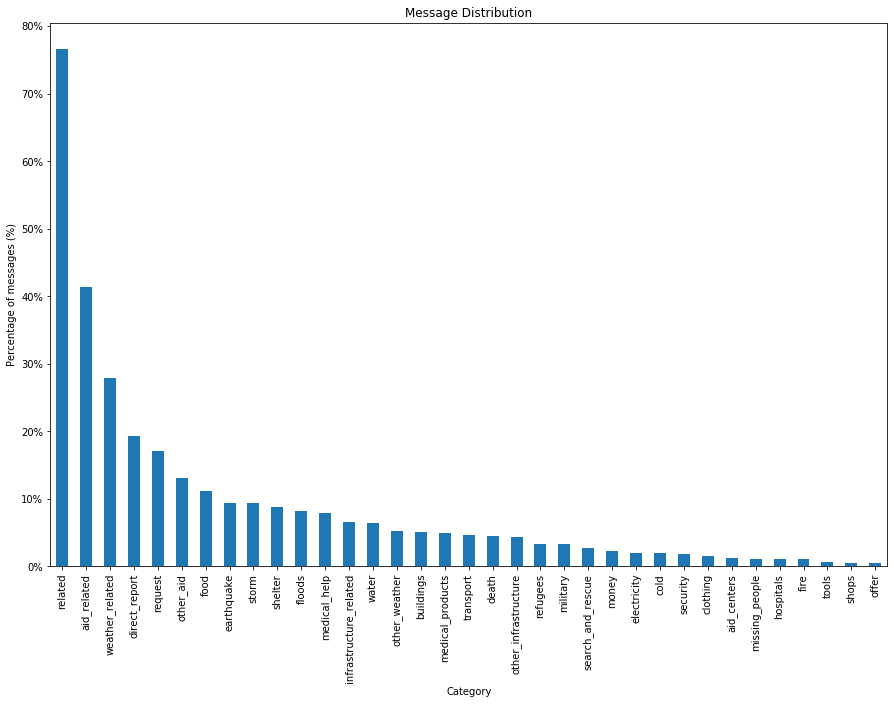

In [136]:
describe_df = df.describe().drop(columns=['id'])
fig = plt.figure(figsize = (15,10))
(describe_df.loc['mean', :].sort_values(ascending=False)).plot(kind='bar');
plt.gca().yaxis.set_major_formatter(PercentFormatter(1));
plt.ylabel('Percentage of messages (%)');
plt.xlabel('Category');
plt.title('Message Distribution');

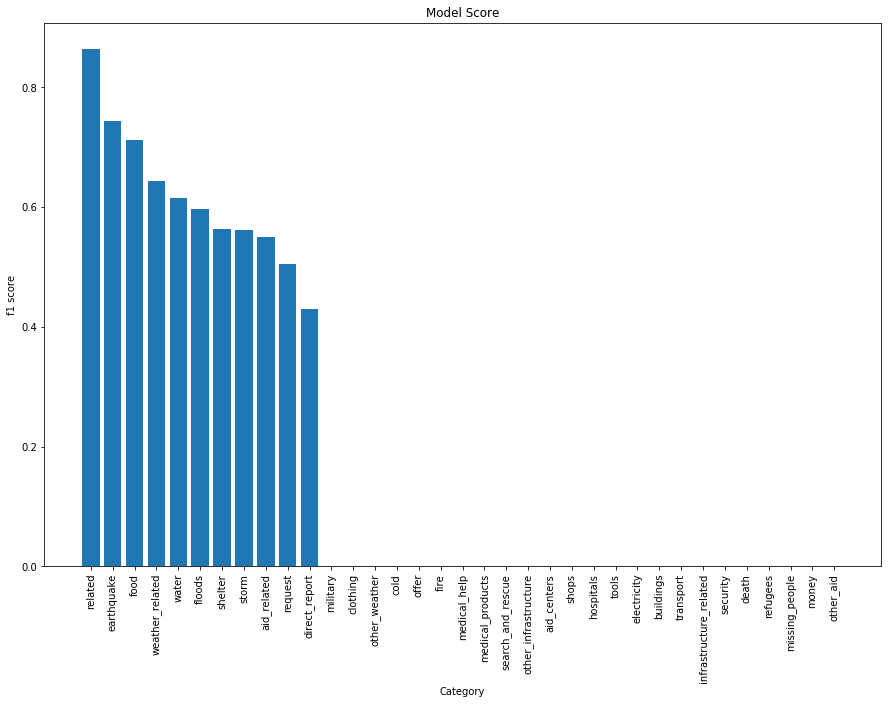

In [137]:
fig = plt.figure(figsize = (15,10))
plt.bar(results['category'], results['f1']);
plt.xticks(rotation='vertical');
plt.ylabel('f1 score');
plt.xlabel('Category');
plt.title('Model Score');

In [138]:
plot_df = pd.concat([results.set_index('category'), pd.DataFrame(describe_df.loc['mean'])], axis=1).sort_values(by='mean', ascending=False)

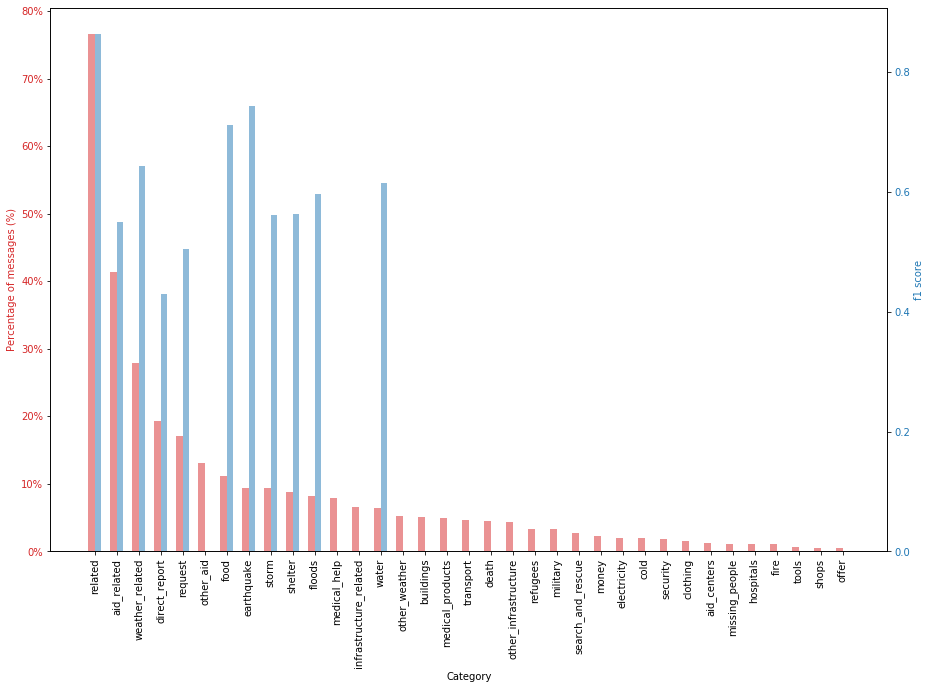

In [139]:

x_names = pd.Series(plot_df.index)

# Creating figures
fig = plt.figure(figsize = (15,10))
ax1 = plt.subplot(1,1,1)

# x_axis and width help to set bar plots next to each other
x_axis = np.arange(len(plot_df.index))
w = 0.3

# Plotting our bar graphs
color = 'tab:red'
ax1.bar(x_axis, plot_df['mean'], width=w, color=color, alpha=0.5, align='center')
ax1.set_ylabel('Percentage of messages (%)', color=color);
ax1.tick_params(axis='y', labelcolor=color)

plt.xticks(x_axis + w /2, x_names, rotation='vertical');
plt.gca().yaxis.set_major_formatter(PercentFormatter(1));
plt.xlabel('Category');

color = 'tab:blue'
ax2 = ax1.twinx() 
ax2.bar(x_axis + w, plot_df['f1'], width=w,color=color, alpha=0.5, align='center')
ax2.set_ylabel('f1 score', color=color);
ax2.tick_params(axis='y', labelcolor=color)


# # Adding values over bars
# for index, value in enumerate(plot_df['Regular Hosts']):
#      plt.text(index-0.05, value*1.001, str(round(value,2)), color = 'C0')
        
# for index, value in enumerate(plot_df['Superhosts']):
#      plt.text(index+0.2, value*1.001, str(round(value,2)), color = 'darkorange')

# Ticks and Labels

# plt.yticks([]);
# plt.legend([reg_p, super_p],['Regular hosts', 'Superhosts']);
# plt.ylabel('Rating (4 - 5 Stars)');
# plt.ylim(4.5,5.05);
# plt.xlabel('Category');
# plt.grid(False)

In [134]:
import pickle

In [138]:
# save the model to disk
filename = 'finalized_model.pkl'
pickle.dump(sgd, open(filename, 'wb'))

In [71]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

0.23256320836966
